In [1]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='grade3')

plt.rcParams[u'font.sans-serif'] = ['simhei'] # 步骤一（替换sans-serif字体）

import warnings
warnings.filterwarnings('ignore')

In [2]:
client = MongoClient("127.0.0.1")
db = client.house
anjuke = db.anjuke

In [115]:
count_anjuke = anjuke.count()

print('房屋数据信息来源:\n安居客：{}条'.format(count_anjuke))

房屋数据信息来源:
安居客：1193条


In [116]:
dataset = pd.DataFrame(list(anjuke.find()))
dataset.drop(['_id'], inplace=True, axis=1)
dataset.head()

,address,bedrooms,house_type,name,price,region,release,status,street,tags,turn
0,广运潭大道与欧亚大道十字东北角,[],办公楼,旭辉荣华公园大道,待定,浐灞,暂无数据,待售,浐河,"[投资地产, 单身公寓, 品牌开发商, 二至三环]",暂无数据
1,雁翔路与春林路十字交汇处向西400米,"[3室户型 , 4室户型 ]",住宅,阳光城PLUS,住宅12000,曲江区,2017-11-10,期房在售,曲江新区,"[品牌开发商, 改善房, 大型社区, 三环以外, 公园]",2019-12-30
2,浐灞秦汉大道与灞河东路交汇处向北200米,"[2室户型 , 3室户型 , 4室户型 ]",住宅,颐馨湿地壹號,住宅8500,城北,2017-10-16,期房在售,港务区,"[南北通透, 三环以外, 双卫, 大阳台, 飘窗]",2019-08-31
3,"马玄路,近二环北路东段","[1室户型 , 2室户型 , 4室户型 , 别墅户型 ]","住宅,别墅,商住",中国铁建西派国际,"住宅17000,商住13000",城北,2017-12-10,期房在售,大明宫,"[轨交房, 品牌开发商, 南北通透, 公交枢纽, 改善房]",2019-12-31
4,东三环和世博大道交会向东300米,"[3室户型 , 4室户型 , 6室户型 ]",住宅,中南樾府,住宅16500,浐灞,2017-12-23,期房在售,世园会,"[轨交房, 品牌开发商, 人车分流, 车位充足, 刚需房]",2020-01-31


## 楼盘筛选
获取的楼盘物业类型包括住宅，别墅，写字楼等各种物业类型。这次分析的目的是买房，所以只关注住宅类型。

In [117]:
dataset['house_type'].value_counts(ascending=False)

住宅             682
住宅,别墅,商住       156
办公楼             88
商住              81
住宅,商住           41
店铺              36
别墅              35
住宅,别墅           34
尚未公开            10
商业街              6
办公楼、商业           4
市场               4
店铺、市场            3
购物中心、商业街         2
商业街、店铺           2
别墅,商住            2
商务公寓、办公楼         1
商务公寓、办公楼、商业      1
酒店式公寓、办公楼        1
商务公寓、酒店式公寓       1
购物中心、商业街、店铺      1
商业街、店铺、市场        1
购物中心、店铺          1
Name: house_type, dtype: int64

In [118]:
# 只保留包含住宅，别墅和商住的物业类型
import re
for x, categorial in enumerate(dataset['house_type']):
    if not re.search(r"住宅", categorial):
        dataset.drop([x], axis=0, inplace=True)
        
dataset['house_type'].value_counts(ascending=False)

住宅          682
住宅,别墅,商住    156
住宅,商住        41
住宅,别墅        34
Name: house_type, dtype: int64

## 哪里的房子多

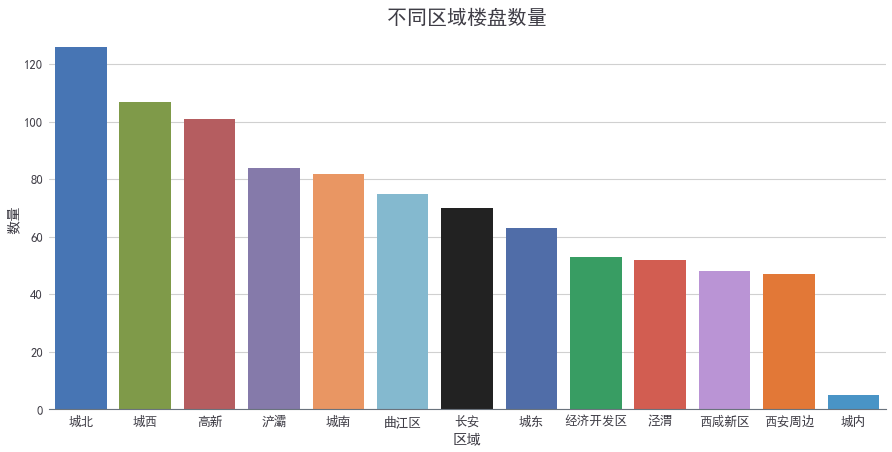

In [119]:
fig = plt.figure(figsize=(15,7))
_ = sns.countplot(x='region', data=dataset, order=dataset['region'].value_counts().index)
_ = plt.xlabel('区域')
_ = plt.ylabel('数量')
_ = plt.title('不同区域楼盘数量', fontsize=20)
_ = sns.despine(left=True)

## 销售状态

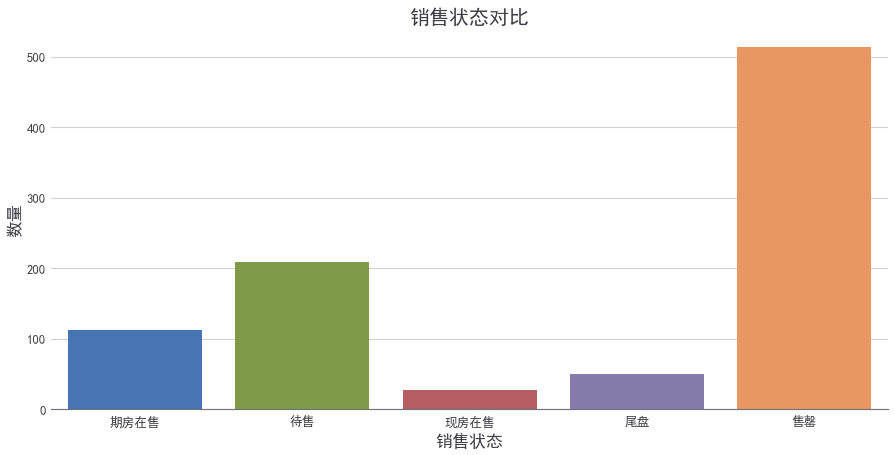

In [120]:
fig = plt.figure(figsize=(15,7))
_ = sns.countplot(x='status', data=dataset)
_ = plt.xlabel('销售状态', fontsize=17)
_ = plt.ylabel('数量', fontsize=17)
_ = plt.title('销售状态对比', fontsize=20)
_ = sns.despine(left=True)

## 哪里的房子最好卖？
不同区域的房子，对购房者的吸引力肯定不一样。大家更喜欢在生活方便，有升值潜力的区域买房子。对比不同区域，不同销售状态的楼盘比例，可以大致反映购房者的喜好和购房的热点。

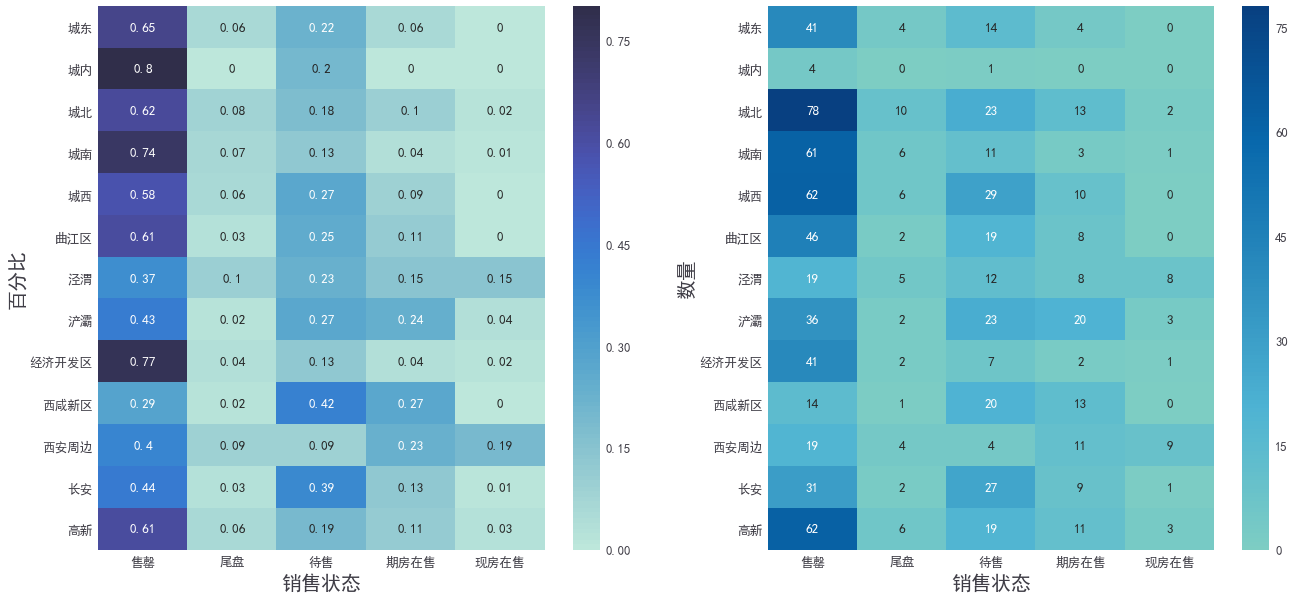

In [121]:
# 将楼盘按照区域和状态分类计数
status = pd.crosstab(dataset['status'], dataset['region'])

# 计算不同销售状态楼盘在相同区域的比例
status_radio = status.apply(lambda x: round(x/x.sum(), 2)).T

fig, ax = plt.subplots(1, 2, figsize=(22, 10))
_ = sns.heatmap(status_radio, annot=True, center=True, ax=ax[0])
_ = ax[0].set_xlabel('销售状态', fontsize=20)
_ = ax[0].set_ylabel('百分比', fontsize=20)
_ = sns.heatmap(status.T, annot=True, center=True, cmap='GnBu', ax=ax[1])
_ = ax[1].set_xlabel('销售状态', fontsize=20)
_ = ax[1].set_ylabel('数量', fontsize=20)

# status_df = pd.DataFrame(np.zeros((len(status_radio.index)*len(status_radio.columns),3)),
#                          columns=['region', 'status', 'radio'])

# i = 0
# for raw in status_radio.index:
#     for col in status_radio.columns:
#         status_df.iloc[i, :] = [raw, col, status_radio.loc[raw, col]]
#         i += 1
        
# fig = plt.figure(figsize=(15,7))
# _ = sns.pointplot(x='region', y='radio', data=status_df, hue='status')
# _ = plt.xlabel('区域')
# _ = plt.ylabel('百分比')
# _ = plt.title('不同区域销售状态对比')
# _ = sns.despine(left=True)
# _ = plt.legend(loc='best')


对比热力图和楼盘区域分布图，可以看出：
1. 城内不是很好的选择，能够选择的空间太小，只有3个楼盘属于可销售(待售×2， 在售×1)
2. 当前，人们更喜欢在城南和经开买房，因为这两个区域的售罄率较高。由于这两个区域的期房和待售楼盘绝对数量不及其他几个区，所以未来这两个区域可能不是投资的热点
3. 未来，会有更多的人居住在三环外，更确切地说是西边和南边，也就是现在投资建设的热点区域，比如<font color='red'>长安，浐灞，城北，城西，高新，西咸</font>等地方。因为这些地方的待售和期房在售，无论数量还是比例，都比其他区域高。

## 户型

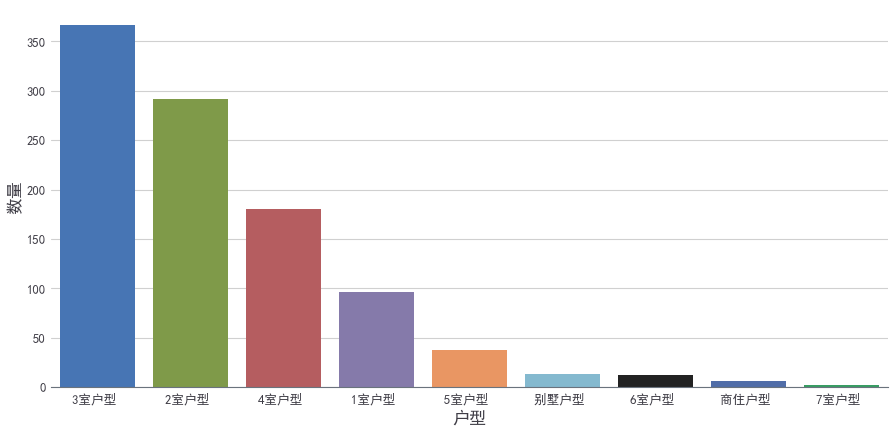

In [159]:
bedrooms = dict()
for item in dataset['bedrooms']:
    if len(item) < 1: continue
    for x in item:
        if x in bedrooms.keys():
            bedrooms[x] += 1
        else:
            bedrooms[x] = 1

bedrooms_df = pd.DataFrame(columns=['type', 'number'])

i = 0
for key, value in bedrooms.items():
    bedrooms_df.loc[len(bedrooms_df)] = [key, value]
    i += 1

fig = plt.figure(figsize=(15,7))
_ = sns.barplot(x='type', y='number', data=bedrooms_df.sort_values(by='number', ascending=False))
_ = plt.xlabel('户型', fontsize=17)
_ = plt.ylabel('数量', fontsize=17)
# _ = plt.title('销售状态对比', fontsize=20)
_ = sns.despine(left=True)

从户型的数量上看，舒适实用的3室和2室户型所占比例最大，其次是较大的4室和较小的1室。满足有钱人需求的5室以上户型只占很小的比例。

## 价格

In [128]:
# 删除售罄的楼盘
dataset.drop(dataset[dataset['status']=='售罄'].index, axis=0, inplace=True)

price = pd.DataFrame(columns=dataset.columns)
for x, item in enumerate(dataset['price']):
    if re.search(r"住宅(\d+)", item):
        price.loc[len(price)] = dataset.iloc[x, :]
        price.loc[len(price)-1, 'house-price'] = re.search(r"住宅(\d+)", item).group(1)
# dataset.drop(dataset[dataset['status']=='售罄'].index, axis=0, inplace=True)
price['house-price'] = price['house-price'].astype(int)

In [152]:
price.groupby('region')['house-price'].mean()

region
城东       13112.500000
城北       10921.153846
城南       12244.555556
城西       11713.333333
曲江区      14850.000000
泾渭        5848.950000
浐灞       10886.600000
经济开发区    14000.000000
西咸新区     10746.153846
西安周边      5775.791667
长安       11200.000000
高新       16645.000000
Name: house-price, dtype: float64

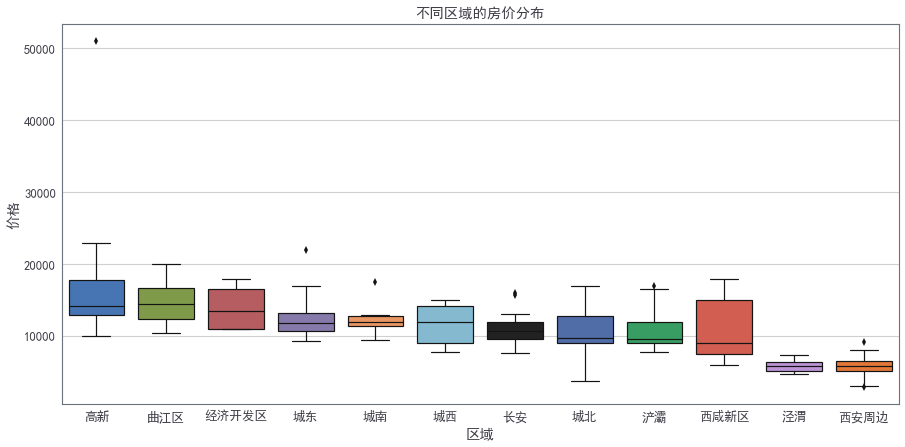

In [157]:
fig = plt.figure(figsize=(15,7))
_ = sns.boxplot(x='region',
                y='house-price',
                data=price,
                order=price.groupby('region')['house-price'].mean()
                           .sort_values(ascending=False).index)
_ = plt.xlabel('区域')
_ = plt.ylabel('价格')
_ = plt.title('不同区域的房价分布')

从不同区域的房价分布上看，高新，曲江，经开已经没有10000以下的房子。高新的房价在整体上和曲江差别不大，但因为高新有单价超过50000的房子，因此拉高了平均价格。<br>
城西，城北，浐灞，西咸房价相对较低。

In [165]:
tags = dict()
for item in dataset['tags']:
    if not isinstance(item, list) or len(item) < 1: continue
    for x in item:
        if x in tags.keys():
            tags[x] += 1
        else:
            tags[x] = 1

In [179]:
tags = str()
for item in dataset['tags']:
    if not isinstance(item, list) or len(item) < 1: continue
    for x in item:
        tags += x + ','

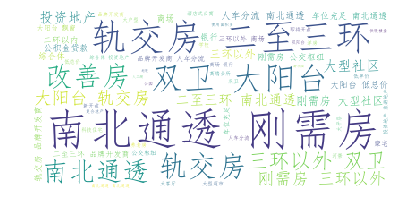

In [190]:
from wordcloud import WordCloud
my_wordcloud = WordCloud(font_path=r'C:\Windows\Fonts\simfang.ttf', background_color='white',
#                          width=800,height=600,
                         max_font_size=50, max_words=1000).generate(tags)
_ = plt.figure("词云图")
_ = plt.imshow(my_wordcloud)
_ = plt.axis("off")

In [191]:
price.to_csv('house.csv')